In [2]:
%matplotlib inline

import cv2
import numpy as np
import copy
from matplotlib import pyplot as plt
import matplotlib.cm as cm

When I started this project I really had multiple goals in mind.  I knew that being able to automate nematode 
assays could be extremely useful both for individual pathology labs as well as the larger NCDA Soil samples.  This successful automation means the program can count worms in a photo, classify them, and remove any debris.  None of this will be done perfectly by a computer, so leaving a methodology open for trained personnel to correct the analysis is important.  

To begin I started with a google search to gather nematode slides.  A good slide should be sufficiently diluted that it is possible to actually count worms, but it is unrealistic that none of the worms will be overlapping.  While these pictures are a good way to test the methodology, they are inconsistant for staging, backlighting, and nematode species.

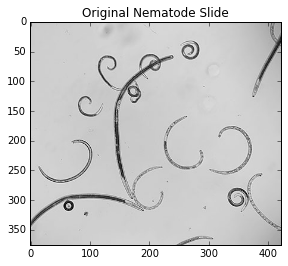

In [3]:
# Reads in the files
filename = '/Users/lehassell/PycharmProjects/nematode/nems.jpg'
original = cv2.imread('nems.jpg', 0)
img = copy.deepcopy(original)
plt.imshow(original, cmap=cm.Greys_r)
plt.title('Original Nematode Slide')
plt.show()

I need to begin the process of extracting meaningful information.  As I recall most nematode assays are done with only the microscope backlight on (this means they are grey scale).  I will start by 
removing noise from the image and select out the foreground.  

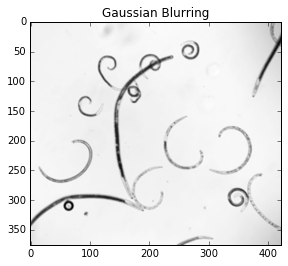

In [4]:
blurred = cv2.GaussianBlur(img, (5, 5), 0)
thresh, th1 = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(blurred, cmap=cm.Greys_r)
plt.title('Gaussian Blurring')
plt.show()

I ran multiple commands in the last block and this demonstrates the first of them.  I applied a Gaussian blurr to smooth out the image.  This removes jagged edges and any small pieces of debris (things smaller than a few     pixels).

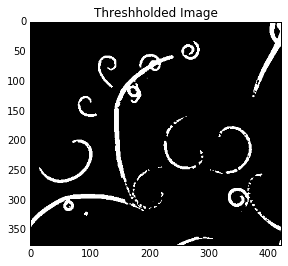

In [5]:
plt.imshow(th1, cmap=cm.Greys_r)
plt.title('Threshholded Image')
plt.show()

This next image shows what happens after I applied a thresholding algorithm.  The goal here was to highlight the pixels that were 'brighter' than the background.  The method used is called the otsu threshold and takes the distribution of pixel brightness frequency and creates two classes that minimize intra-class variance.  

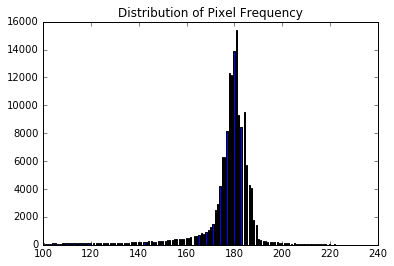

In [6]:
plt.hist(original.ravel(),256,[100,225])
plt.title('Distribution of Pixel Frequency')
plt.show()

At this point I should be ready to have my program find the contours of objects in the image.  The program will pick anything in the foreground (the white) and note the bounds.  

In [7]:
image, contours, hierarchy = cv2.findContours(th1, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
img_1 = copy.deepcopy(original)
img_2 = copy.deepcopy(original)
print(len(contours))

62


The print line tells me how many total objects/contours the program has detected - 62.  That seems a bit high, lets visualize the contours by putting a minimum bounding circle around each object.

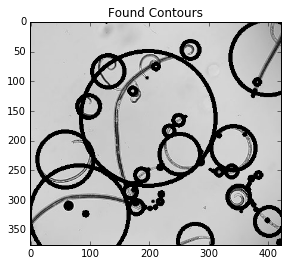

In [17]:
for cnt in contours:
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        center = (int(x), int(y))
        radius = int(radius)
        circle_image = cv2.circle(img_1, center, radius, (0, 255, 0), 5)

plt.imshow(circle_image, cmap=cm.Greys_r)
plt.title('Found Contours')
plt.show()

It definitely seems to be finding objects.  However there are a lot of little circles for objects we aren't concerned with.  Lets try setting only minimum radii.

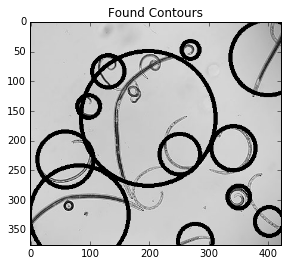

In [18]:
for cnt2 in contours:
        (x, y), radius = cv2.minEnclosingCircle(cnt2)
        center = (int(x), int(y))
        radius = int(radius)
        if radius > 12:
            circle_image_2 = cv2.circle(img_2, center, radius, (0, 255, 0), 5)

plt.imshow(circle_image_2, cmap=cm.Greys_r)
plt.title('Found Contours')
plt.show()

By limiting the size of the radius, we were able to help focus where the program looks.  If all we wanted to do is count nematodes then this is probably not a bad place to get the model to.  It got 12 out of 15 (80%).  The user can simply add missing worms to the tally with a quick visual assessment.

Demo with two other photos:


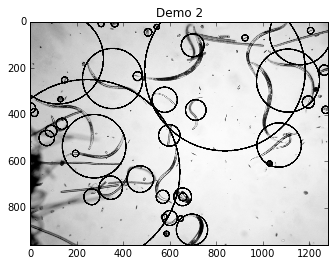

In [31]:
filename_2 = '/Users/lehassell/PycharmProjects/nematode/nems3_circle.jpg'
demo_2 = cv2.imread(filename_2, 0)

filename_3 = '/Users/lehassell/PycharmProjects/nematode/nems4_circle.jpg'
demo_3 = cv2.imread(filename_3, 0)

plt.imshow(demo_2, cmap=cm.Greys_r)
plt.title('Demo 2')
plt.show()

The plate has quite a bit of debris in it.

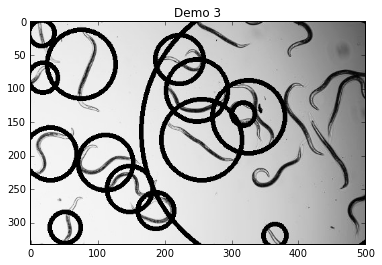

In [33]:
plt.imshow(demo_3, cmap=cm.Greys_r)
plt.title('Demo 3')
plt.show()

This one was almost perfect until it got the right side.  We can see where the slide/plate was on the edge and the light gradient has interfered with the thresholding.  15/21 Nematodes (70%)

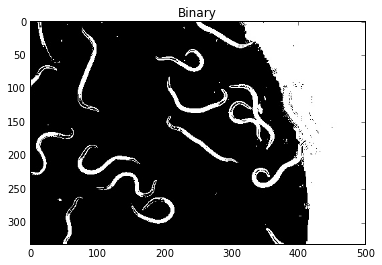

In [35]:
filename_binary = '/Users/lehassell/PycharmProjects/nematode/binary_nem4.jpg'
demo_binary = cv2.imread(filename_binary, 0)

plt.imshow(demo_binary, cmap=cm.Greys_r)
plt.title('Binary')
plt.show()

These are random samples taken from google image search that were collected with very different techniques (different microscope settings for backlight for example).  With a consistant source it should be possible to improve this process.